# Prepare the base.json file
After finishing this notebook run ```src/data_processing/prepare_train_test.py```.

In [776]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from string2string.alignment import LongestCommonSubsequence, LongestCommonSubstring
from string2string.distance import JaccardIndex
from string2string.misc.default_tokenizer import Tokenizer
import numpy as np

from sklearn.model_selection import train_test_split

In [777]:
generated = pd.read_csv("../data/generated_outputs.csv")
# generated = generated[temperatures].melt().rename({"variable": "temperature", "value": "text"}, axis=1)

In [778]:
original = pd.read_csv("../summaries.csv")

In [779]:
new = pd.read_csv("../data/processed_responses.csv").drop("HITId", axis=1)

In [781]:
qids = pd.read_csv("../data/qids.csv")

In [782]:
# temperatures = [str(k) for k in [0.3, 0.5, 0.7, 0.9, 1]]
temperatures = [str(k) for k in [0.7, 0.9]]

In [783]:
def extract_answer(text):
    pattern = r"<FreeText>(.*?)</FreeText>"
    matches = re.findall(pattern, text, re.DOTALL)

    return matches[1]
original["Answer"] = original["Answer"].apply(lambda x: extract_answer(x))

In [784]:
# generated["texts"] = generated["text"].apply(lambda x: x[4:20]).str.lower()
# qids["question"] = qids["question"].apply(lambda x: x[4:20]).str.lower()

In [785]:
# new["original_text"] = new["original_text"].apply(lambda x: x[4:20]).str.lower()

In [786]:
original = original[["Question", "Answer"]]

In [787]:
len(qids["HITId"].unique())

16

In [788]:
new["match_on"] = new["original_text"].apply(lambda x: " ".join(x.split()[0:3]))
qids["match_on"] = qids["question"].apply(lambda x: " ".join(x.split()[0:3]))

In [789]:
new = new.merge(qids, on="match_on")

In [790]:
abstracts = new[["original_text", "HITId"]]

In [794]:
new = new[["HITId","summary"]]

In [795]:
abstracts = abstracts.drop_duplicates().reset_index(drop=True)

In [796]:
abstracts

,original_text,HITId
0,Comparison of Weight-Loss Diets with Different...,NEJMoa0804748
1,Effect of Screening Mammography on Breast-Canc...,NEJMoa1000727
2,"First Results of Phase 3 Trial of RTS,S/AS01 M...",NEJMoa1102287
3,Azithromycin and the Risk of Cardiovascular De...,NEJMoa1003833
4,Effect of Sibutramine on Cardiovascular Outcom...,NEJMoa1003114
5,Exemestane for Breast-Cancer Prevention in Pos...,NEJMoa1103507
6,Effect of Three Decades of Screening Mammograp...,NEJMoa1206809
7,Primary Prevention of Cardiovascular Disease w...,NEJMoa1200303
8,Waning Protection after Fifth Dose of Acellula...,NEJMoa1200850
9,Changes in Diet and Lifestyle and Long-Term We...,NEJMoa1014296


In [424]:
# new = new[new["text"].map(len) > 150]

In [797]:
abstracts.merge(original.rename({"Question": "HITId"}, axis=1), on="HITId")

,original_text,HITId,Answer
0,Comparison of Weight-Loss Diets with Different...,NEJMoa0804748,The possible advantage for weight loss of a di...
1,Comparison of Weight-Loss Diets with Different...,NEJMoa0804748,The advantage for weight loss on a diet that e...
2,Comparison of Weight-Loss Diets with Different...,NEJMoa0804748,We compared the result of weight loss with fou...
3,Comparison of Weight-Loss Diets with Different...,NEJMoa0804748,A trial was conducted to see whether weight lo...
4,Comparison of Weight-Loss Diets with Different...,NEJMoa0804748,A research study examined the effect of weight...
...,...,...,...
123,Global Sodium Consumption and Death from Cardi...,NEJMoa1304127,The risk of death from high sodium consumption...
124,Global Sodium Consumption and Death from Cardi...,NEJMoa1304127,While high sodium increases blood pressure and...
125,Global Sodium Consumption and Death from Cardi...,NEJMoa1304127,High blood pressure is a risk factor for cardi...
126,Global Sodium Consumption and Death from Cardi...,NEJMoa1304127,A global study was done on whether high sodium...


In [798]:
def prepare_for_finetuning(gen, real, abstracts):
    real = real.rename({"Question":"HITId", "Answer":"text"}, axis=1)
    gen = gen[["HITId", "text"]]
    
    # add labels
    real["labels"] = "real"
    real["class"] = "old-summaries"
    gen["labels"] = "synthetic"
    gen["class"] = "gen-summaries"

    abstracts["labels"] = "real"
    abstracts["class"] = "abstract"
    abstracts = abstracts.rename({"original_text":"text"}, axis=1)

    return pd.concat([real, gen, abstracts], axis=0).sample(frac=1)


for_training = prepare_for_finetuning(generated, original, abstracts)

for_training.to_json("../data/base.json", orient="records", indent=2)

/tmp/ipykernel_2799387/3115519750.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen["labels"] = "synthetic"


In [803]:
for_training["length"] = for_training["text"].apply(lambda x: len(x))

In [808]:
for_training

,HITId,text,labels,class,length
296,NEJMoa1404037,Aromatase inhibitors are a type of hormone the...,synthetic,gen-summaries,968
204,NEJMoa021134,A study was conducted on children born in Denm...,synthetic,gen-summaries,741
171,NEJMoa1200850,A study has shown that protection against pert...,synthetic,gen-summaries,771
213,NEJMoa021134,A study was conducted on children born in Denm...,synthetic,gen-summaries,770
207,NEJMoa021134,A study conducted in Denmark on the link betwe...,synthetic,gen-summaries,668
...,...,...,...,...,...
245,NEJMoa1112010,A large study has found that drinking coffee m...,synthetic,gen-summaries,782
141,NEJMoa1200303,A randomized trial has concluded that a Medite...,synthetic,gen-summaries,733
82,NEJMoa1014296,Dietary and other lifestyle behaviors may affe...,real,old-summaries,950
28,NEJMoa1103507,A study of 4560 women aged 62.5 years and the ...,real,old-summaries,1019


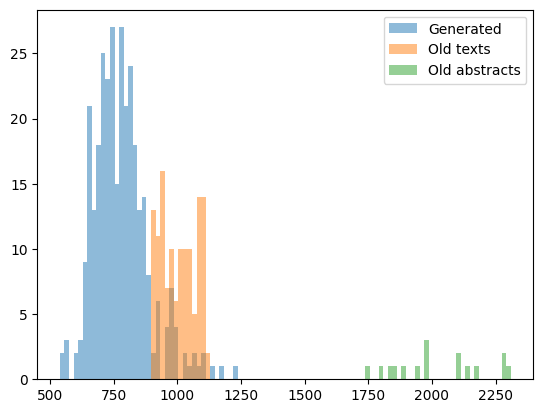

In [813]:
bins = np.linspace(for_training["length"].min(), for_training["length"].max(), 100)

fig, ax = plt.subplots()

x1 = for_training[for_training["class"]=="gen-summaries"]["length"]
x2 = for_training[for_training["class"]=="old-summaries"]["length"]
x3 = for_training[for_training["class"]=="abstract"]["length"]

ax.hist(x1, bins, label="Generated", alpha=0.5)
ax.hist(x2, bins, label="Old texts", alpha=0.5)
ax.hist(x3, bins, label="Abstracts", alpha=0.5)

ax.legend()

In [816]:
def construct_simple_length_based_label(x):
    if x >= 900:
        return "real"
    else:
        return "synthetic"

In [817]:
for_training["simple-prediction"] = for_training["length"].apply(lambda x: construct_simple_length_based_label(x))

In [821]:
for_training.groupby(["labels", "simple-prediction"])["HITId"].count()

labels     simple-prediction
real       real                 144
synthetic  real                  32
           synthetic            288
Name: HITId, dtype: int64